# Feature Engineering

In [4]:
from src.setup import *
%load_ext rpy2.ipython

In [2]:
%%capture --no-stdout err
%%R 
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to connect to bus: Host is down


## Date/time fields

In [3]:
%%bash
zcat data/glarp/outside.gz | head -5

2003 07 25 16 04 27.500000
2003 07 25 16 07 27.300000
2003 07 25 16 10 27.300000
2003 07 25 16 13 27.400000
2003 07 25 16 16 27.800000


In [4]:
temps = pd.read_csv('data/glarp/outside.gz', 
                    sep=' ', header=None, 
                    names=['year', 'month', 'day', 
                           'hour', 'minute', 'degrees'])
temps.head(5)

,year,month,day,hour,minute,degrees
0,2003,7,25,16,4,27.5
1,2003,7,25,16,7,27.3
2,2003,7,25,16,10,27.3
3,2003,7,25,16,13,27.4
4,2003,7,25,16,16,27.8


### Creating Datetimes

In [5]:
ts_fields = ['year', 'month', 'day', 'hour', 'minute']
temps.index = pd.to_datetime(temps[ts_fields])
temps.drop(columns=ts_fields, inplace=True)
temps

,degrees
2003-07-25 16:04:00,27.5
2003-07-25 16:07:00,27.3
2003-07-25 16:10:00,27.3
2003-07-25 16:13:00,27.4
...,...
2004-07-16 15:19:00,16.9
2004-07-16 15:22:00,16.8
2004-07-16 15:25:00,16.8
2004-07-16 15:28:00,16.4


In [6]:
temps.index.is_monotonic_increasing

False

In [7]:
increments = temps.index.to_series().diff()
increments[increments < pd.Timedelta(minutes=0)]

2003-10-26 01:01:00   -1 days +23:03:00
dtype: timedelta64[ns]

In [8]:
temps.sort_index(inplace=True)
temps.index.is_monotonic_increasing

True

### Imposing Regularity

In [9]:
increments = temps.index.to_series().diff()
gaps = increments[increments > pd.Timedelta(minutes=3)]
gaps

2003-07-26 19:28:00   0 days 00:06:00
2003-07-27 09:10:00   0 days 00:06:00
2003-07-29 08:28:00   0 days 00:06:00
2003-07-29 11:43:00   0 days 00:06:00
                            ...      
2004-07-05 19:55:00   0 days 07:36:00
2004-07-06 09:28:00   0 days 00:06:00
2004-07-06 16:28:00   0 days 00:06:00
2004-07-14 04:04:00   0 days 00:06:00
Length: 160, dtype: timedelta64[ns]

In [10]:
with show_more_rows():
    print(gaps.sort_values(ascending=False).head(15))

2003-12-11 03:04:00   1 days 13:48:00
2004-04-28 00:31:00   0 days 13:06:00
2004-07-05 19:55:00   0 days 07:36:00
2003-12-18 09:25:00   0 days 06:33:00
2003-12-06 09:25:00   0 days 06:24:00
2003-12-29 08:46:00   0 days 06:03:00
2003-12-11 14:19:00   0 days 04:42:00
2004-04-04 03:01:00   0 days 01:03:00
2004-06-30 18:13:00   0 days 00:33:00
2003-11-24 08:04:00   0 days 00:30:00
2003-10-11 17:13:00   0 days 00:27:00
2003-12-13 17:10:00   0 days 00:15:00
2004-07-02 09:22:00   0 days 00:12:00
2004-06-30 03:07:00   0 days 00:12:00
2004-06-22 10:16:00   0 days 00:12:00
dtype: timedelta64[ns]


In [11]:
temps.loc['2003-07-26 19:22:00':'2003-07-26 19:28:00']

,degrees
2003-07-26 19:22:00,27.5
2003-07-26 19:28:00,27.1


In [12]:
small_steps = increments[increments < pd.Timedelta(minutes=3)]
small_steps.sort_values(ascending=False)

2003-10-03 12:04:00   0 days 00:02:00
2003-10-26 01:01:00   0 days 00:00:00
2003-12-24 15:10:00   0 days 00:00:00
2003-10-26 01:58:00   0 days 00:00:00
                            ...      
2003-10-26 01:13:00   0 days 00:00:00
2003-10-26 01:10:00   0 days 00:00:00
2003-10-26 01:07:00   0 days 00:00:00
2003-12-24 15:10:00   0 days 00:00:00
Length: 22, dtype: timedelta64[ns]

In [13]:
temps.loc['2003-10-03 11:57':'2003-10-03 12:08']

,degrees
2003-10-03 11:58:00,13.0
2003-10-03 12:02:00,12.8
2003-10-03 12:04:00,12.8
2003-10-03 12:07:00,12.8


### Duplicated Timestamps

In [14]:
# Show all rows that are part of duplicate set
# Other `keep` options will drop some or all duplicates
temps[temps.index.duplicated(keep=False)]

,degrees
2003-10-26 01:01:00,1.9
2003-10-26 01:01:00,0.9
2003-10-26 01:07:00,1.9
2003-10-26 01:07:00,1.1
...,...
2003-10-26 01:58:00,0.1
2003-12-24 15:10:00,6.4
2003-12-24 15:10:00,20.9
2003-12-24 15:10:00,6.4


In [15]:
no_dups = (temps
             .reset_index()  # De-dup on named column
             .drop_duplicates(keep='first', subset='index')
             .set_index('index'))

print(f"Length of original DataFrame: {len(temps):,}")
print(f"Length of de-duped DataFrame: {len(no_dups):,}")

# Check if datetime index is now unique
no_dups.index.is_unique

Length of original DataFrame: 169,513
Length of de-duped DataFrame: 169,492


True

In [16]:
mean_dups = temps.groupby(temps.index).mean()

print(f"Length of mean-by-duplicate: {len(mean_dups):,}")
mean_dups.index.is_unique

Length of mean-by-duplicate: 169,492


True

### Adding Timestamps

In [17]:
# See Pandas docs, it is easy to confuse M=month with m=minute
no_dups.resample('1M').mean()

,degrees
index,
2003-07-31,21.508462
2003-08-31,20.945075
2003-09-30,14.179293
2003-10-31,12.544181
...,...
2004-04-30,7.708277
2004-05-31,14.357831
2004-06-30,15.420425
2004-07-31,20.527493


In [18]:
# Groupby both month number and name
by_month = no_dups.groupby(
    [no_dups.index.month, no_dups.index.month_name()])
# The mean temperature over the month
by_month = by_month.mean()
# Discard the month number now that result is sorted
by_month = by_month.droplevel(0)
# Name the index
by_month.index.name = 'month_name'
by_month

,degrees
month_name,
January,0.433968
February,-0.209109
March,7.848025
April,7.708277
...,...
September,14.179293
October,12.544181
November,2.332037
December,0.667080


In [19]:
filled_temps = no_dups.asfreq('3T')
filled_temps

,degrees
index,
2003-07-25 16:04:00,27.5
2003-07-25 16:07:00,27.3
2003-07-25 16:10:00,27.3
2003-07-25 16:13:00,27.4
...,...
2004-07-16 15:19:00,16.9
2004-07-16 15:22:00,16.8
2004-07-16 15:25:00,16.8
2004-07-16 15:28:00,16.4


In [20]:
sum(filled_temps.degrees.isnull())

1858

In [21]:
one_minute_temps = no_dups.asfreq('1T')
one_minute_temps.index.name = 'Timestamp'
one_minute_temps

,degrees
Timestamp,
2003-07-25 16:04:00,27.5
2003-07-25 16:05:00,NaN
2003-07-25 16:06:00,NaN
2003-07-25 16:07:00,27.3
...,...
2004-07-16 15:25:00,16.8
2004-07-16 15:26:00,NaN
2004-07-16 15:27:00,NaN
2004-07-16 15:28:00,16.4


In [22]:
one_minute_temps.interpolate(method='spline', order=3, 
                             inplace=True)
one_minute_temps.head()

,degrees
Timestamp,
2003-07-25 16:04:00,27.500000
2003-07-25 16:05:00,27.082346
2003-07-25 16:06:00,27.079049
2003-07-25 16:07:00,27.300000
2003-07-25 16:08:00,27.072395


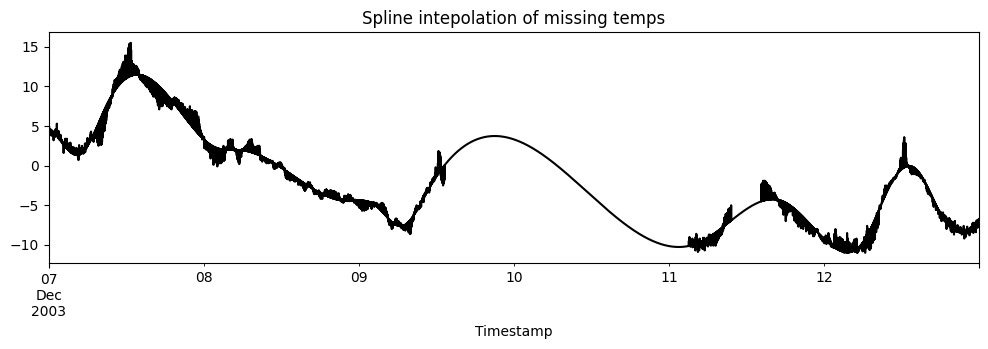

In [23]:
(one_minute_temps
     .loc['2003-12-07':'2003-12-12', 'degrees']
     .plot(title="Spline intepolation of missing temps", 
           figsize=(12,3)))
plt.savefig("img/(Ch07)Spline intepolation of missing temps.png")

## String fields

In [34]:
df = pd.read_fwf('data/parts2.fwf')
df

,Part_No,Description,Maker,Price
0,12345,Wankle rotary engine,Acme Corporation,$ 555.55
1,No.678,Sousaphone,Marching Inc.,$ 333.33
2,2468,Feather Duster,Sweeps Bros,$ 22.22
3,#9922,Area 51 metal fragment,No Such Agency,$9999.99


In [35]:
# Regular expression to strip all non-digits
df['Part_No'] = (df.Part_No
                     .str.replace(r'[^0-9]', '', regex = True)
                     .astype(np.uint16))

# Remove spaces or $ from start of strings
df['Price'] = (df.Price
                   .str.lstrip("$ ")
                   .astype(float))

In [36]:
df.dtypes

Part_No         uint16
Description     object
Maker           object
Price          float64
dtype: object

In [37]:
df

,Part_No,Description,Maker,Price
0,12345,Wankle rotary engine,Acme Corporation,555.55
1,678,Sousaphone,Marching Inc.,333.33
2,2468,Feather Duster,Sweeps Bros,22.22
3,9922,Area 51 metal fragment,No Such Agency,9999.99


### Fuzzy Matching

In [38]:
names = pd.read_csv('data/names.csv', index_col='Group')
names.head(8)

,Last_Name,Other_Data
Group,,
1,Levenshtein,103
1,Levenschtein,158
1,Levenstein,110
2,Hagelin,136
2,Haslam,105
2,Haugland,190
2,Heislen,181
2,Heslin,106


In [ ]:
!pip install metaphone

In [41]:
from metaphone import doublemetaphone

metas = zip(*names.Last_Name.map(doublemetaphone))
names['meta1'], names['meta2'] = metas

In [42]:
with show_more_rows():
    print(names.loc[6])

      Last_Name  Other_Data meta1 meta2
Group                                  
6         Jeong         191   JNK   ANK
6          Jong         157   JNK   ANK
6         Chŏng         100   XNK      
6         Chung         123   XNK      
6          Jung         118   JNK   ANK
6         Joung         168   JNK   ANK
6         Chong         101   XNK      
6        Cheong         133   XNK      
6        Choung         104   XNK      


In [43]:
with show_more_rows():
    print(names.loc[5])

       Last_Name  Other_Data meta1 meta2
Group                                   
5        Gadaffi         197   KTF      
5         Gadafi         189   KTF      
5         Gadafy         181   KTF      
5        Gaddafi         163   KTF      
5        Gaddafy         179   KTF      
5        Gadhafi         112   KTF      
5        Gathafi         187   K0F   KTF
5       Ghadaffi         141   KTF      
5        Ghadafi         152   KTF      
5       Ghaddafi         192   KTF      
5       Ghaddafy         122   KTF      
5       Gheddafi         142   KTF      
5        Kadaffi         139   KTF      
5         Kadafi         188   KTF      
5        Kaddafi         192   KTF      
5        Kadhafi         121   KTF      
5        Kazzafi         193   KSF  KTSF
5       Khadaffy         148   KTF      
5        Khadafy         157   KTF      
5       Khaddafi         134   KTF      
5         Qadafi         136   KTF      
5        Qaddafi         173   KTF      
5        Qadhafi

In [44]:
with show_more_rows():
    print(names.loc[names.index < 5])

          Last_Name  Other_Data   meta1 meta2
Group                                        
1       Levenshtein         103  LFNXTN      
1      Levenschtein         158  LFNXTN      
1        Levenstein         110  LFNSTN      
2           Hagelin         136    HJLN  HKLN
2            Haslam         105    HSLM      
2          Haugland         190   HKLNT      
2           Heislen         181     HLN      
2            Heslin         106    HSLN      
2           Hicklin         151    HKLN      
2          Highland         172   HHLNT      
2          Hoagland         174   HKLNT      
3           Schmidt         107     XMT   SMT
3             Shmit         167     XMT      
3             Smith         160     SM0   XMT
3             Smitt         181     SMT   XMT
3              Smit         192     SMT   XMT
4             Mertz         173    MRTS      
4              Merz         116     MRS      
4            Mertes         178    MRTS      
4             Hertz         188   

### Explicit Categories

In [45]:
humans = pd.read_csv('data/humans-names.csv')
humans

,Name,Height,Weight
0,James,167.089607,64.806216
1,David,181.648633,78.281527
2,Barbara,176.272800,87.767722
3,John,173.270164,81.635672
...,...,...,...
24996,Michael,163.952580,68.936137
24997,Marie,164.334317,67.830516
24998,Robert,171.524117,75.861686
24999,James,174.949129,71.620899


In [46]:
name_counts = humans.Name.value_counts()
uncommon = name_counts[name_counts < 10]
humans = (humans
              .set_index('Name')
              .drop(uncommon.index)
              .reset_index())
humans

,Name,Height,Weight
0,James,167.089607,64.806216
1,David,181.648633,78.281527
2,Barbara,176.272800,87.767722
3,John,173.270164,81.635672
...,...,...,...
24579,Michael,163.952580,68.936137
24580,Marie,164.334317,67.830516
24581,Robert,171.524117,75.861686
24582,James,174.949129,71.620899


In [47]:
humans['Name'] = humans.Name.astype('category')
humans.Name.dtype

CategoricalDtype(categories=['Barbara', 'David', 'Elizabeth', 'James', 'Jennifer',
                  'Jessica', 'John', 'Jon', 'Joseph', 'Linda', 'Marie', 'Mary',
                  'Michael', 'Patricia', 'Richard', 'Robert', 'Susan',
                  'William'],
, ordered=False, categories_dtype=object)

In [48]:
humans[humans.Name == 'Mary']

,Name,Height,Weight
19,Mary,170.513197,71.145258
35,Mary,175.783570,73.843096
54,Mary,166.074242,70.826540
61,Mary,175.258933,78.888337
...,...,...,...
24532,Mary,172.602398,72.602118
24536,Mary,172.159574,70.383305
24547,Mary,173.902497,71.545191
24549,Mary,169.510964,71.460077


In [49]:
%%capture --no-stdout err
%%R
humans <- read_csv('data/humans-names.csv')
humans

Rows: 25000 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Name
dbl (2): Height, Weight

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 25,000 × 3
   Name      Height Weight
   <chr>      <dbl>  <dbl>
 1 James       167.   64.8
 2 David       182.   78.3
 3 Barbara     176.   87.8
 4 John        173.   81.6
 5 Michael     172.   82.8
 6 William     174.   70.7
 7 Elizabeth   177.   81.2
 8 Joseph      178.   78.3
 9 Jessica     172.   64.5
10 William     170.   69.2
# ℹ 24,990 more rows
# ℹ Use `print(n = ...)` to see more rows


In [50]:
%%R
# Make the column Name into a factor variable
humans <- mutate_at(humans, vars(Name), factor) 

# Any values occurring fewer than 100 times will be 
# aggregated under then factor level "UNCOMMON"
humans['Name'] <- fct_lump_min(humans$Name, min = 100, 
                               other_level = "UNCOMMON")
humans

# A tibble: 25,000 × 3
   Name      Height Weight
   <fct>      <dbl>  <dbl>
 1 James       167.   64.8
 2 David       182.   78.3
 3 Barbara     176.   87.8
 4 John        173.   81.6
 5 Michael     172.   82.8
 6 William     174.   70.7
 7 Elizabeth   177.   81.2
 8 Joseph      178.   78.3
 9 Jessica     172.   64.5
10 William     170.   69.2
# ℹ 24,990 more rows
# ℹ Use `print(n = ...)` to see more rows


In [51]:
%%R
levels(humans$Name)

 [1] "Barbara"   "David"     "Elizabeth" "James"     "Jennifer"  "Jessica"  
 [7] "John"      "Jon"       "Joseph"    "Linda"     "Marie"     "Mary"     
[13] "Michael"   "Patricia"  "Richard"   "Robert"    "Susan"     "William"  
[19] "UNCOMMON" 


In [52]:
%%R
humans %>% filter(Name == "UNCOMMON")

# A tibble: 417 × 3
   Name     Height Weight
   <fct>     <dbl>  <dbl>
 1 UNCOMMON   172.   76.5
 2 UNCOMMON   167.   60.3
 3 UNCOMMON   182.   85.2
 4 UNCOMMON   176.   72.3
 5 UNCOMMON   174.   82.1
 6 UNCOMMON   170.   66.8
 7 UNCOMMON   171.   60.0
 8 UNCOMMON   171.   73.9
 9 UNCOMMON   171.   80.4
10 UNCOMMON   177.   73.3
# ℹ 407 more rows
# ℹ Use `print(n = ...)` to see more rows


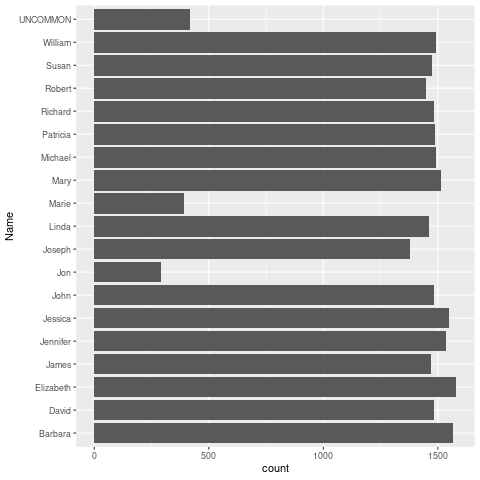

In [53]:
%%R
im <- ggplot(humans, aes(y = Name)) + geom_bar(stat = "count")
im

In [54]:
%%capture --no-stdout err
%%R
ggsave("img/(Ch07)name-histogram-with-uncommon.png", dpi=600)

Saving 6.67 x 6.67 in image


## String Vectors

In [2]:
# William Butler Yeats
second_coming = """
Turning and turning in the widening gyre   
The falcon cannot hear the falconer;
Things fall apart; the centre cannot hold;
Mere anarchy is loosed upon the world,
The blood-dimmed tide is loosed, and everywhere   
The ceremony of innocence is drowned;
The best lack all conviction, while the worst   
Are full of passionate intensity.

Surely some revelation is at hand;
Surely the Second Coming is at hand.   
The Second Coming! Hardly are those words out   
When a vast image out of Spiritus Mundi
Troubles my sight: somewhere in sands of the desert   
A shape with lion body and the head of a man,   
A gaze blank and pitiless as the sun,   
Is moving its slow thighs, while all about it   
Reel shadows of the indignant desert birds.   
The darkness drops again; but now I know   
That twenty centuries of stony sleep
Were vexed to nightmare by a rocking cradle,   
And what rough beast, its hour come round at last,   
Slouches towards Bethlehem to be born?
"""

In [5]:
def simplify_text(text):
    stops = nltk.corpus.stopwords.words('english')
    words = re.findall(r'[a-z]+', text.lower())
    return [w for w in words if w not in stops]

poem = simplify_text(second_coming)
poem[:6]

['turning', 'turning', 'widening', 'gyre', 'falcon', 'cannot']

In [6]:
word2ndx = {w:n for (n, w) in enumerate(set(poem))}
print(f"Vector dimensions={len(word2ndx)}")

def make_vector(words, word2ndx=word2ndx):
    # Generate the vector of zero count per dimension
    vec = np.zeros(len(word2ndx), dtype=np.uint16)
    for word in words:
        # we might ignore unknown word or attempt 
        # to canonicalize it, here we raise exception
        assert word in word2ndx
        n = word2ndx[word]
        vec[n] += 1
    return vec

list(word2ndx.items())[:5]

Vector dimensions=84


[('falcon', 0), ('dimmed', 1), ('hour', 2), ('last', 3), ('words', 4)]

In [7]:
for i, stanza in enumerate(second_coming.split('\n\n')):
    print(f"Stanza {i+1}:")
    print(make_vector(simplify_text(stanza)))

Stanza 1:
[1 1 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0
 1 0 1 0 0 0 0 0 0 1 2 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 2 0 0 1 0 0 1 0 2 1 0
 0 0 1 1 1 1 0 0 0 0]
Stanza 2:
[0 0 1 1 1 1 2 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 2 1 1 1 1 0 1
 0 2 0 1 1 1 1 1 1 0 0 1 1 2 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1
 1 1 0 0 0 0 2 1 1 1]


In [8]:
db = sqlite3.connect('data/Airline-Tweets.sqlite')
cur = db.cursor()

sql = """
SELECT name, airline, text 
FROM Tweets 
"""
cur.execute(sql)
tweets = cur.fetchall()
pprint(tweets[5000:5003], width=60)

[('Paul_Faust',
  'United',
  '@united Love to report how horrible this flight is to '
  "your team. Let's make it worse...as they get to my "
  'seat...out of all snacks'),
 ('Jennsaint8',
  'Southwest',
  '@SouthwestAir any chance they will change this to '
  'include Northeast airports?  JetBlue has.'),
 ('_stephanieejayy',
  'Delta',
  '@JetBlue do you have any afternoon flights going from '
  'BQN to JFK? I only seem to find early morning flights.')]


In [ ]:
!pip install --upgrade gensim
# restart the kernel

In [9]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

docs = []
for (author, airline, msg) in tweets:
    td = TaggedDocument(simplify_text(msg), [author, airline])
    docs.append(td)

# Require words occur at least 4x, look 2 words to each side
# The produced vector is 10 dimensional
model = Doc2Vec(docs, vector_size=10, window=2, min_count=4)

In [11]:
print("Number of words:", len(model.wv.index_to_key))
list(model.wv.key_to_index)[:7]

Number of words: 3359


['united',
 'flight',
 'usairways',
 'americanair',
 'southwestair',
 'jetblue',
 'get']

In [12]:
msg = tweets[11_001][2]
print(msg)
model.infer_vector(simplify_text(msg))

@AmericanAir thank you for responding rather quickly btw


array([-0.04338666, -0.1596374 , -0.13851959, -0.11083671, -0.02469394,
       -0.02636589,  0.10275329, -0.16033235, -0.3941465 , -0.40132207],
      dtype=float32)

In [13]:
badservice = model.infer_vector(['bad', 'service'])
badservice

array([ 0.01028982, -0.01029472, -0.07406542, -0.09274689, -0.01865385,
       -0.04349611, -0.02674023, -0.0259037 ,  0.0122519 , -0.12773861],
      dtype=float32)

In [14]:
airlines = ('Delta', 'United', 'JetBlue')
delta, united, jetblue = (model.docvecs[x] for x in airlines)
print(f"Delta:\n{delta}\n")
print(f"United:\n{united}\n")
print(f"JetBlue:\n{jetblue}\n")

Delta:
[-1.52127    -2.3590174  -4.3186183  -4.9296927  -0.38914594 -1.9413637
  0.6615115   5.0510488  -9.451831   -9.609143  ]

United:
[-2.8761196 -5.755101  -1.8010364 -5.724102   1.6656172 -3.8141003
  3.426973  -1.1337922 -1.2238384 -8.749978 ]

JetBlue:
[-0.00912944 -0.06442876  0.09061412 -0.06688263  0.04503469 -0.07784047
 -0.0549182  -0.02002615  0.05514987  0.04012597]



In [15]:
from scipy.spatial.distance import cosine
print(f"Delta  | United  | {cosine(delta, united):.3f}")
print(f"Delta  | JetBlue | {cosine(delta, jetblue):.3f}")
print(f"United | JetBlue | {cosine(united, jetblue):.3f}")

Delta  | United  | 0.308
Delta  | JetBlue | 1.274
United | JetBlue | 0.837


## Decompositions

### Rotation and whitening

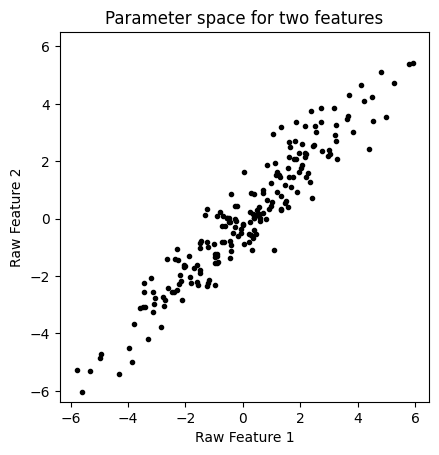

In [16]:
from src.whiten import data, show

# Only two initial features for illustration, 
# but in general we would have a highly dimensionality
show(data, "Parameter space for two features", 
     "Raw Feature 1", "Raw Feature 2")

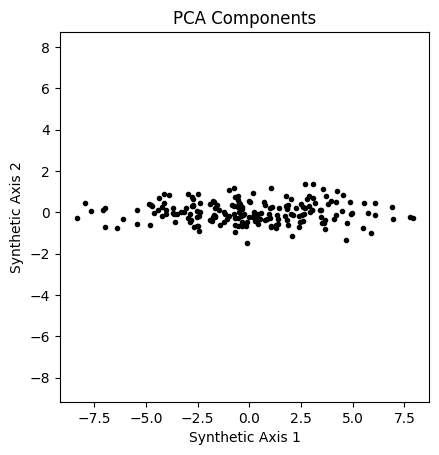

In [17]:
from sklearn.decomposition import PCA
show(PCA().fit_transform(data), 
     "PCA Components", "Synthetic Axis 1", "Synthetic Axis 2")

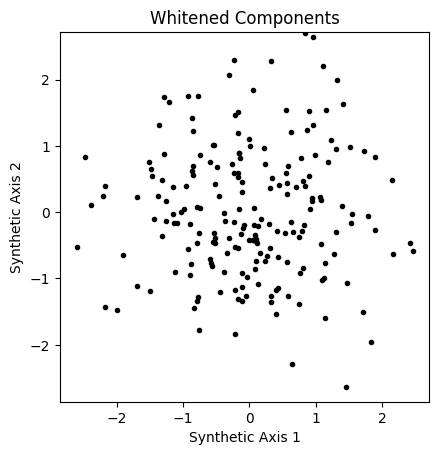

In [18]:
show(PCA(whiten=True).fit_transform(data), 
     "Whitened Components", "Synthetic Axis 1", "Synthetic Axis 2")

### Dimensionality Reduction

In [19]:
cancer = load_breast_cancer()
X_raw = StandardScaler().fit_transform(cancer.data)
y = cancer.target

In [20]:
X_pca1 = PCA(n_components=1, whiten=True).fit_transform(X_raw)
X_pca2 = PCA(n_components=2, whiten=True).fit_transform(X_raw)
X_pca4 = PCA(n_components=4, whiten=True).fit_transform(X_raw)

In [21]:
for X in (X_raw, X_pca1, X_pca2, X_pca4):
    X_train, X_test, y_train, y_test = (
        train_test_split(X, y, random_state=1))
    model = KNeighborsClassifier().fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    error_rate = 100*(1-accuracy)
    print(f"Features | {X.shape=}\t| {error_rate=:.2f}%")

Features | X.shape=(569, 30)	| error_rate=4.90%
Features | X.shape=(569, 1)	| error_rate=9.79%
Features | X.shape=(569, 2)	| error_rate=6.99%
Features | X.shape=(569, 4)	| error_rate=4.20%


In [22]:
pca3 = PCA(n_components=3).fit(X_raw)
pd.DataFrame(pca3.components_.T, 
             index=cancer.feature_names, 
             columns=['pca_1', 'pca_2', 'pca_3'])

,pca_1,pca_2,pca_3
mean radius,0.218902,-0.233857,-0.008531
mean texture,0.103725,-0.059706,0.064550
mean perimeter,0.227537,-0.215181,-0.009314
mean area,0.220995,-0.231077,0.028700
...,...,...,...
worst concavity,0.228768,0.097964,-0.173057
worst concave points,0.250886,-0.008257,-0.170344
worst symmetry,0.122905,0.141883,-0.271313
worst fractal dimension,0.131784,0.275339,-0.232791


In [23]:
row0_sk = pca3.transform(X_raw)[0]
row0_np = (pca3.components_ * X_raw[0]).sum(axis=1)
print(f"Row 0 as transform: {row0_sk}")
print(f"Row 0 as mul/sum:   {row0_np}")

Row 0 as transform: [ 9.19283683  1.94858307 -1.12316616]
Row 0 as mul/sum:   [ 9.19283683  1.94858307 -1.12316616]


### Visualization

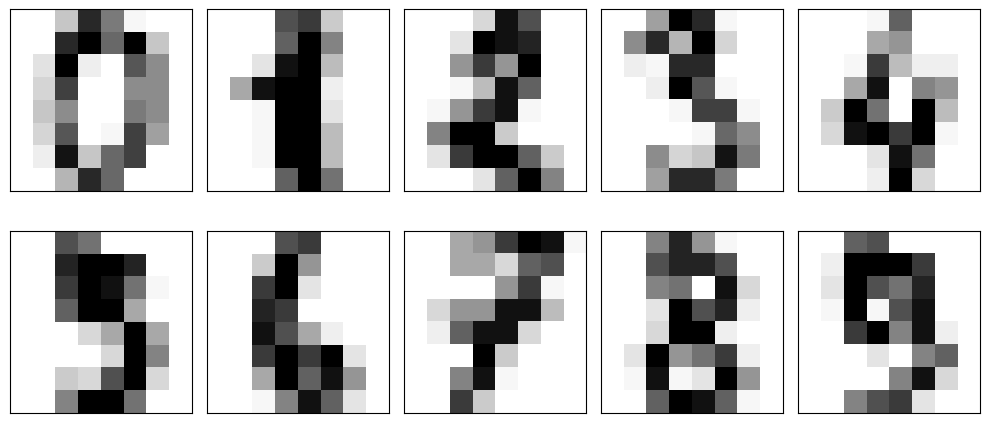

In [24]:
digits = get_digits()

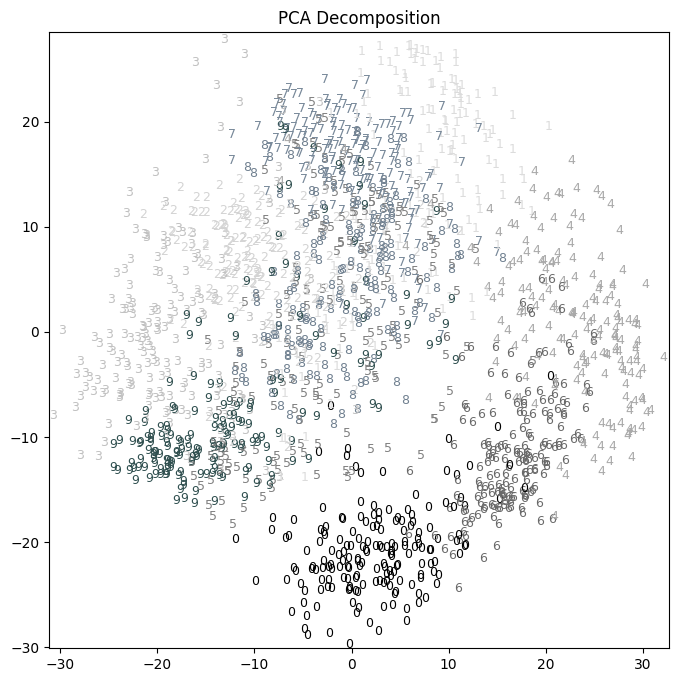

In [25]:
pca_digits = PCA(n_components=2).fit_transform(digits.data)
plot_digits(pca_digits, digits, "PCA")

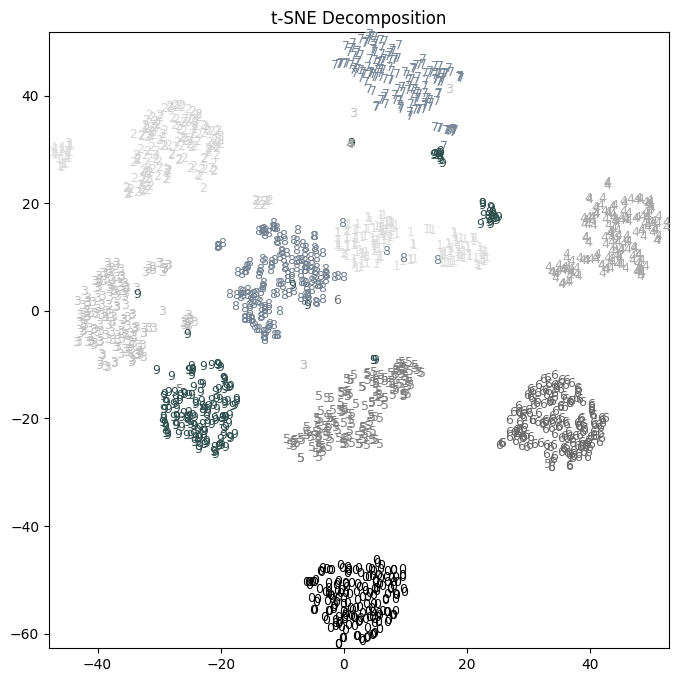

In [26]:
tsne_digits = TSNE(random_state=1).fit_transform(digits.data)
plot_digits(tsne_digits, digits, "t-SNE")

## Quantization and Binarization

In [27]:
survey = pd.read_csv('data/ML-survey.csv')
survey.sample(6, random_state=1)

,Language,Experience,Age,Post_Secondary,Success
95,C++,1.0,57,12,7
44,Python,7.0,24,11,5
56,R,2.0,46,9,10
97,Python,2.0,23,3,5
69,Python,5.0,53,4,8
114,Python,25.0,76,23,1


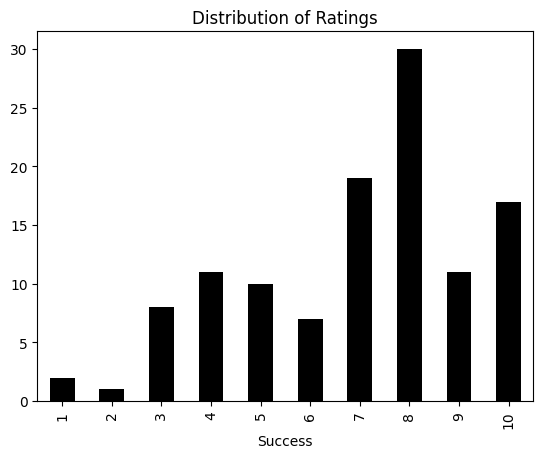

In [28]:
title="Distribution of Ratings"
(survey
    .Success
    .value_counts()
    .sort_index()
    .plot(kind='bar', title=title))
plt.savefig(f'img/(Ch07){title}.png')

In [29]:
survey.Success >= 8

0       True
1       True
2       True
3      False
       ...  
112    False
113     True
114    False
115     True
Name: Success, Length: 116, dtype: bool

In [30]:
from sklearn.preprocessing import Binarizer

# Set threshold anywhere *between* 7 and 8
binary_rating = Binarizer(threshold=7.5)

# Pass 2-D DataFrame, not Series
success = binary_rating.fit_transform(survey[['Success']])

# Maintaining versions is good practice
survey2 = survey.copy()
survey2['Success'] = success
survey2

,Language,Experience,Age,Post_Secondary,Success
0,Python,20.0,53,13,1
1,Python,4.0,33,7,1
2,Python,1.0,31,10,1
3,Python,12.0,60,12,0
...,...,...,...,...,...
112,Python,4.0,35,4,0
113,Python,3.0,44,6,1
114,Python,25.0,76,23,0
115,Python,25.0,75,12,1


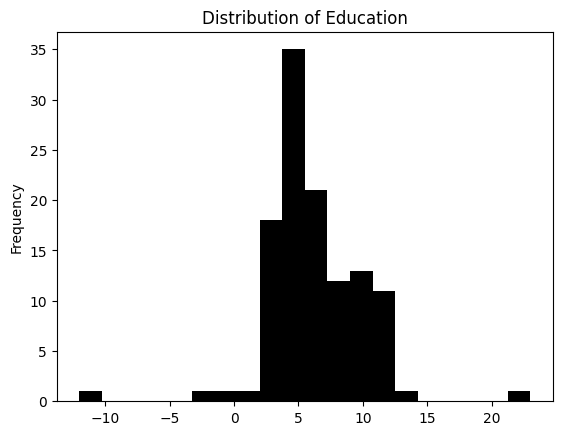

In [31]:
title="Distribution of Education"
(survey2
    .Post_Secondary
    .plot(kind="hist", bins=20, title=title))
plt.savefig(f'img/(Ch07){title}.png')

In [32]:
from sklearn.preprocessing import KBinsDiscretizer

# Create a binner with 3 balanced bins
edu_bin = KBinsDiscretizer(n_bins=3, 
                           encode='ordinal', 
                           strategy='quantile')

# Bin the Post_Secondary column
level = edu_bin.fit_transform(survey2[['Post_Secondary']])

# In this version, rename the binned field "Education"
survey3 = survey2.copy()
survey3['Education'] = level.astype(np.uint8)
survey3.drop('Post_Secondary', axis=1, inplace=True)
survey3.sample(8, random_state=2)

,Language,Experience,Age,Success,Education
24,Python,3.0,28,1,0
89,Python,12.0,46,0,2
28,Python,3.0,31,1,1
56,R,2.0,46,1,2
2,Python,1.0,31,1,2
53,Python,10.0,3,1,2
45,Python,1.0,31,0,2
79,JavaScript,1.0,32,1,1


In [33]:
print("Education cut-offs:")
print(edu_bin.bin_edges_[0], '\n')
print("Count per bin:")
print(survey3.Education.value_counts())

Education cut-offs:
[-12.           4.33333333   7.          23.        ] 

Count per bin:
Education
2    44
0    39
1    33
Name: count, dtype: int64


In [34]:
# Create a binner with 5 bins of same numeric range
exp = KBinsDiscretizer(n_bins=5, 
                       encode='ordinal', 
                       strategy='uniform')

# Bin the Experience column
exp_level = exp.fit_transform(survey3[['Experience']])

# Retain the Experience name, but new meaning
survey4 = survey3.copy()
survey4['Experience'] = exp_level.astype(np.uint8)
survey4.sample(8, random_state=3)

,Language,Experience,Age,Success,Education
83,MATLAB,1,37,0,2
5,Python,0,32,1,0
6,Python,0,34,0,2
42,MATLAB,0,31,0,2
100,Python,0,47,0,2
97,Python,0,23,0,0
40,Python,1,33,1,2
25,R,0,36,1,0


In [35]:
print("Experience cut-offs:")
print(exp.bin_edges_[0], '\n')
print("Count per bin:")
print(survey4
        .Experience.value_counts()
        .sort_index())

Experience cut-offs:
[ 0.   5.4 10.8 16.2 21.6 27. ] 

Count per bin:
Experience
0    93
1    14
2     4
3     1
4     4
Name: count, dtype: int64


In [36]:
survey4.Age.describe()[['mean', 'min', 'max']]

mean    36.965517
min      3.000000
max     99.000000
Name: Age, dtype: float64

In [37]:
survey[survey.Age < 10]

,Language,Experience,Age,Post_Secondary,Success
53,Python,10.0,3,9,9
85,Python,3.0,3,10,6


In [38]:
# Create next version and impute for bad data
survey5 = survey4.copy()
survey5.loc[survey5.Age == 3, 'Age'] = 35

# Create a binner with 3 bins to 3 columns
# Note: a sparse array with "onehot"
age_bin = KBinsDiscretizer(n_bins=3, 
                           encode='onehot-dense', 
                           strategy='quantile')

# Bin and split the Age column
age = age_bin.fit_transform(survey5[['Age']])
age = age.astype(np.uint8).T
survey5 = survey5.assign(Young=age[0], 
                         Mid_Age=age[1], 
                         Old=age[2])
survey5.drop('Age', axis=1, inplace=True)
survey5.sample(8, random_state=4)

,Language,Experience,Success,Education,Young,Mid_Age,Old
13,Python,0,0,2,0,1,0
2,Python,0,1,2,0,1,0
25,R,0,1,0,0,1,0
16,Python,0,1,0,0,0,1
19,Python,0,0,1,0,0,1
79,JavaScript,0,1,1,0,1,0
5,Python,0,1,0,0,1,0
24,Python,0,1,0,1,0,0


## One-Hot Encoding

In [39]:
survey6 = pd.get_dummies(survey5, prefix="Lang")
survey6.sample(10, random_state=3).T.tail(8)

,83,5,6,42,100,97,40,25,115,103
Lang_C++,False,False,False,False,False,False,False,False,False,False
Lang_JavaScript,False,False,False,False,False,False,False,False,False,False
Lang_MATLAB,True,False,False,True,False,False,False,False,False,False
Lang_Python,False,True,True,False,True,True,True,False,True,False
Lang_R,False,False,False,False,False,False,False,True,False,True
Lang_Scala,False,False,False,False,False,False,False,False,False,False
Lang_VB,False,False,False,False,False,False,False,False,False,False
Lang_Whitespace,False,False,False,False,False,False,False,False,False,False


In [42]:
from sklearn.preprocessing import OneHotEncoder
lang = survey5[['Language']]
enc = OneHotEncoder(sparse_output=False).fit(lang)
one_hot = enc.transform(lang)
print(enc.get_feature_names_out())
print("\nA few encoded rows:")
print(one_hot[80:90])

['Language_C++' 'Language_JavaScript' 'Language_MATLAB' 'Language_Python'
 'Language_R' 'Language_Scala' 'Language_VB' 'Language_Whitespace']

A few encoded rows:
[[0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]]


In [43]:
with show_more_rows():
    print(survey6.loc[0])

Experience             3
Success                1
Education              2
Young                  0
Mid_Age                0
Old                    1
Lang_C++           False
Lang_JavaScript    False
Lang_MATLAB        False
Lang_Python         True
Lang_R             False
Lang_Scala         False
Lang_VB            False
Lang_Whitespace    False
Name: 0, dtype: object


## Polynomial Features

In [44]:
cancer = load_breast_cancer()
X_raw = MinMaxScaler().fit_transform(cancer.data)
y = cancer.target

### Generating Synthetic Features

In [45]:
poly = dict()
X_poly = dict()

print(f"Raw data set shape:  {cancer.data.shape}")

for n in [2, 3, 4, 5]:
    poly[n] = PolynomialFeatures(n)
    X_poly[n] = poly[n].fit_transform(X_raw)
    print(f"Degree {n} polynomial: {X_poly[n].shape}")

Raw data set shape:  (569, 30)
Degree 2 polynomial: (569, 496)
Degree 3 polynomial: (569, 5456)
Degree 4 polynomial: (569, 46376)
Degree 5 polynomial: (569, 324632)


In [47]:
names = poly[2].get_feature_names_out(cancer.feature_names)

row0 = pd.Series(X_poly[2][0], index=names)
row0.sample(8, random_state=6)

mean compactness^2                       0.627323
radius error worst perimeter             0.238017
smoothness error worst concavity         0.090577
mean compactness worst concavity         0.450361
perimeter error                          0.369034
area error fractal dimension error       0.050119
radius error concavity error             0.048323
mean fractal dimension symmetry error    0.188707
dtype: float64

In [49]:
names = poly[4].get_feature_names_out(cancer.feature_names)
row0 = pd.Series(X_poly[4][0], index=names)
row0.sample(6, random_state=2)

mean texture mean symmetry concavity error worst fractal dimension      0.000884
mean texture mean perimeter mean smoothness                             0.007345
mean concave points compactness error worst perimeter^2                 0.114747
fractal dimension error worst radius worst perimeter worst symmetry     0.045447
mean compactness mean fractal dimension worst area worst compactness    0.133861
mean area worst compactness worst concave points^2                      0.187367
dtype: float64

In [52]:
%%R
library(tibble)

X <- tibble(A = c(0.2, 0.3, 0.4), 
            B = c(0.1, -0.3, 0.5),
            C = c(-0.2, 0.3, 0.1))
formula = ~ .^3 
poly2 <- as_tibble(model.matrix(formula, data=X))
poly2

# A tibble: 3 × 8
  `(Intercept)`     A     B     C `A:B` `A:C` `B:C` `A:B:C`
          <dbl> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>   <dbl>
1             1   0.2   0.1  -0.2  0.02 -0.04 -0.02  -0.004
2             1   0.3  -0.3   0.3 -0.09  0.09 -0.09  -0.027
3             1   0.4   0.5   0.1  0.2   0.04  0.05   0.02 


### Feature Selection

In [53]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, 
                               n_jobs=4, random_state=2)

In [54]:
rfecv = RFECV(estimator=model, n_jobs=-1)
best_feat = rfecv.fit(X_poly[2], y)
X_support = X_poly[2][:, best_feat.support_]
X_support.shape

(569, 337)

In [55]:
for X in (X_raw, X_poly[2], X_support):
    X_train, X_test, y_train, y_test = (
        train_test_split(X, y, random_state=42))
    model.fit(X_train, y_train) 
    accuracy = model.score(X_test, y_test)
    error_rate = 100*(1-accuracy)
    print(f"Features | {X.shape=}\t| {error_rate=:.2f}%")

Features | X.shape=(569, 30)	| error_rate=2.80%
Features | X.shape=(569, 496)	| error_rate=1.40%
Features | X.shape=(569, 337)	| error_rate=0.70%


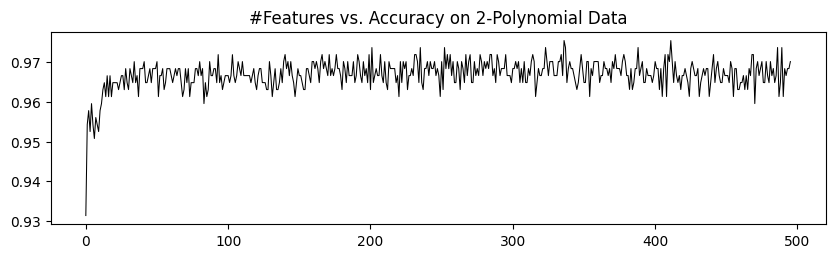

In [57]:
title = "#Features vs. Accuracy on 2-Polynomial Data"
(pd.Series(best_feat.cv_results_['mean_test_score'])
     .plot(figsize=(10, 2.5), linewidth=0.75, title=title))
plt.savefig(f'img/(Ch07){title}.png')